<a href="https://colab.research.google.com/github/drdrwenski/sympy-examples/blob/main/MinkowskiMetric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metric Tensor in Minkowski Space

The metric tensor in Minkowski space is fundamental to the structure and mathematics of special relativity. It defines the spacetime interval, which is invariant under Lorentz transformations, and provides the means to calculate proper time and distance. It ensures the consistency of physical laws across different inertial frames and underpins the entire framework of special relativity by defining the geometry of spacetime.

## Preliminaries

First, we define some output helper functions:

In [1]:
from IPython.display import display, Markdown
from sympy.tensor.tensor import Tensor, TensMul
from sympy import latex
import re

def get_tensor_indices(expr):
  indices = []
  if isinstance(expr, Tensor):
    indices.extend(expr.get_indices())
  elif hasattr(expr, 'args'):
    for subexpr in expr.args:
      indices.extend(get_tensor_indices(subexpr))
  indices = list(dict.fromkeys(indices))
  return indices

def get_free_indices(expr):
  indices = []
  if isinstance(expr, TensMul):
    indices.extend(expr.get_free_indices())
  elif isinstance(expr, Tensor):
    indices.extend(expr.get_free_indices())
  elif hasattr(expr, 'args'):
    for subexpr in expr.args:
      indices.extend(get_free_indices(subexpr))
  indices = list(dict.fromkeys(indices))
  return indices

def prettyLatex(expr, **kwargs):
  output = rf'{latex(expr)}'
  repl = kwargs.get('repl', [])
  for old, new in repl:
    output = output.replace(old, new)
  indices = kwargs.get('indices', [])
  if (indices):
    expr_indices = get_tensor_indices(expr)
    free_indices = get_free_indices(expr)
    matches = indices.get('metric_name','L') + r'_(\d+)'
    replace = indices.get('metric_name','L') + r'_{\1}'
    dummy_indices = [ re.sub(matches, replace, index.name)
      for index in expr_indices if index not in free_indices ]
    dummy_indices = list(dict.fromkeys(dummy_indices))
    unused_indices = [rf'\{index.name}' for index in indices.get('tensor_indices',[])
      if index not in free_indices and -index not in free_indices ]
    for (i,j) in zip(dummy_indices, unused_indices):
      output = output.replace(i,j)
  return output

def displayLatex(expr, **kwargs):
  intro = kwargs.get('intro', '')
  coda = kwargs.get('coda', '')
  output = rf'$\displaystyle {intro} {prettyLatex(expr,**kwargs)} {coda}$'
  display(Markdown(output))


## Spacetime Coordinates

The Minkowski space consists of a set of events, denoted as $M$, where each event is a point in a four-dimensional manifold. For any $p\in M$, there exists a local time coordinate $t$ and three spatial coordinates $(x, y, z)$ that describe the neighborhood around the event $p$. These coordinates form a local frame of reference in the manifold $M$, allowing for the tools of **differential geometry** and **tensor calculus** to be applied. For the start, we consider **Cartesian coordinates** to introduce the well-known Minkowski metric.

In [2]:
from sympy import symbols
from sympy.diffgeom import Manifold, Patch, CoordSystem
from sympy.diffgeom import twoform_to_matrix, TensorProduct as TP

Minkowski = Manifold('M', 4)
SpaceTime = Patch('ST', Minkowski)
M4 = CoordSystem('Cartesian', SpaceTime, symbols('t x y z'))

t, x, y, z = M4.base_scalars()
dt, dx, dy, dz = M4.base_oneforms()
Lorentz_metric = TP(dt,dt) - TP(dx,dx) - TP(dy,dy) - TP(dz,dz)
displayLatex(Lorentz_metric, intro = 'ds^2 =\ ')
displayLatex(twoform_to_matrix(Lorentz_metric), intro = '(g_{ij}) = ')

$\displaystyle ds^2 =\  \operatorname{d}t \otimes \operatorname{d}t - \operatorname{d}x \otimes \operatorname{d}x - \operatorname{d}y \otimes \operatorname{d}y - \operatorname{d}z \otimes \operatorname{d}z $

$\displaystyle (g_{ij}) =  \left[\begin{matrix}1 & 0 & 0 & 0\\0 & -1 & 0 & 0\\0 & 0 & -1 & 0\\0 & 0 & 0 & -1\end{matrix}\right] $

The metric of Minkowski space is a flat space **Lorentz metric**. The signature $(+,-,-,-)$ of the metric tensor reflects the fact that time has a different character than the spatial dimensions. The metric tensor transforms contravariant four-vectors into their covariant counterparts (and vice versa).

In [3]:
from sympy.tensor.tensor import TensorIndexType, TensorHead, tensor_indices
from sympy import Eq

# Define tensor index type for Lorentz indices
Lorentz = TensorIndexType('Lorentz', metric_name='g', dim=4)
g = Lorentz.metric

# Define tensor indices
mu, nu, alpha, beta = tensor_indices('mu nu alpha beta', Lorentz)
Lorentz_indices = {
    'tensor_indices': [alpha, beta, mu, nu],
    'metric_name': Lorentz.dummy_name
}

"""
dummy_indices0 = [('L_{0}', r'\mu'), ('L_{1}', r'\nu'), ('Eps', r'\epsilon')]
dummy_indices1 = [('L_{0}', r'\beta'), ('L_{1}', r'\alpha'), ('Eps', r'\epsilon')]
"""

# Define a 4-vector V
four_vector = TensorHead('V', [Lorentz])

# Transform contravariant 4-vector
V_prime = g(-alpha, -beta) * four_vector(beta)
contraction = Eq(V_prime, V_prime.contract_metric(g))  # .canon_bp())
# displayLatex(contraction, repl=dummy_indices1)
displayLatex(contraction, indices=Lorentz_indices)

# Apply the inverse metric tensor
V_prime = g(alpha, mu) *g(-mu, -nu) * four_vector(nu)
contraction = Eq(V_prime, V_prime.contract_metric(g))  # .canon_bp())
# displayLatex(contraction, repl=dummy_indices0)
displayLatex(contraction, indices=Lorentz_indices)

$\displaystyle  g{}_{\alpha\beta}V{}^{\beta} = V{}_{\alpha} $

$\displaystyle  g{}^{\alpha\beta}g{}_{\beta\mu}V{}^{\mu} = V{}^{\alpha} $

Throughout this notebook, we assume **natural units** of length and time such that the numerical value for the speed of light becomes $c = 1$ in every reference frame. In particular, if $V = (t,x,y,z)$ denotes the vector difference between two events in Minkowski space, then the corresponding **spacetime interval** is formed as given below.

In [4]:
# Bundle replacements for tensor contractions
replacements = {
    Lorentz: twoform_to_matrix(Lorentz_metric),
    four_vector(mu): M4.base_scalars()
}

# Define spacetime interval (i.e. proper time)
proper_time = g(-mu, -nu) * four_vector(mu) * four_vector(nu)
contracted = proper_time.contract_metric(g)
tau = contracted.replace_with_arrays(replacements)

displayLatex(Eq(proper_time, contracted), indices=Lorentz_indices,
    intro=r'\tau=\ ', coda=rf' \ =\ {latex(tau)}')

$\displaystyle \tau=\  g{}_{\alpha\beta}V{}^{\alpha}V{}^{\beta} = V{}^{\alpha}V{}_{\alpha}  \ =\ \mathbf{t}^{2} - \mathbf{x}^{2} - \mathbf{y}^{2} - \mathbf{z}^{2}$

Proper time $\tau$ refers to the time interval measured by a clock that is moving along with the object or observer in question.

## The Lorentz Transformation

In the following example, the transformation $\Lambda$ is used to transform a 4-vector $V$ into a new 4-vector $V'$ under the Lorentz boost in the $x$-direction.

In [5]:
# Define tensor for the Lorentz transformation
Lambda_tensor = TensorHead('Lambda', [Lorentz, Lorentz])

# Apply the Lorentz transformation to the 4-vector
V_prime = Lambda_tensor(alpha, -beta) * four_vector(beta)
displayLatex(V_prime, indices=Lorentz_indices, intro='V\'^{\\,\\alpha} =\ ')

$\displaystyle V'^{\,\alpha} =\  \Lambda{}^{\alpha}{}_{\beta}V{}^{\beta} $

In special relativity the Galilean law of addition of velocities is replaced (at least for subsequent Lorentz boosts in the same direction) by a simple addition rule for a hyperbolic angle called the **rapidity**. For a velocity $v$, the rapidity $\eta$ is defined such that $v = c \tanh \eta$.

In [6]:
from sympy import cosh, sinh, Matrix

# Define rapidity parameters
eta, zeta, xi = symbols('eta zeta xi')
lorentz_factor, ratio_vc = symbols('gamma beta')

# Define Lorentz transformation matrix
Lambda_matrices = [
    Matrix([
        [cosh(eta), -sinh(eta), 0, 0],
        [-sinh(eta), cosh(eta), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])
]

In [7]:
"""
from sympy import cosh, sinh, Matrix

# Define rapidity parameters
eta, zeta = symbols('eta zeta')
lorentz_factor, ratio_vc = symbols('gamma beta')
Eta_tensor = TensorHead('Eta', [Lorentz, Lorentz])
Zeta_tensor = TensorHead('Zeta', [Lorentz, Lorentz])

# Define Lorentz transformation matrix
Lambda_matrix = Matrix([
    [cosh(eta), -sinh(eta), 0, 0],
    [-sinh(eta), cosh(eta), 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])
"""

Eta_tensor = TensorHead('Eta', [Lorentz, Lorentz])
Zeta_tensor = TensorHead('Zeta', [Lorentz, Lorentz])
Xi_tensor = TensorHead('Xi', [Lorentz, Lorentz])

# Update replacements for the Lorentz transformation
replacements.update({
    Eta_tensor(mu, -nu): Lambda_matrices[0],
    Zeta_tensor(mu, -nu): Lambda_matrices[0].subs(eta, zeta)
})

# Display the transformed components
V_prime = Zeta_tensor(alpha, -mu) * Eta_tensor(mu, -nu) * four_vector(nu)
vec_prime = V_prime.replace_with_arrays(replacements).simplify()
vec_prime_alt = vec_prime.subs([
    (cosh(eta+zeta), lorentz_factor),
    (sinh(eta+zeta), ratio_vc * lorentz_factor)
])
displayLatex(Matrix(vec_prime),
    intro = prettyLatex(V_prime, indices=Lorentz_indices) + r'\;=\;',
    coda = r'\;=\;' + prettyLatex(Matrix(vec_prime_alt)))

$\displaystyle \mathrm{Z}{}^{\alpha}{}_{\beta}\mathrm{H}{}^{\beta}{}_{\mu}V{}^{\mu}\;=\; \left[\begin{matrix}- \sinh{\left(\eta + \zeta \right)} \mathbf{x} + \cosh{\left(\eta + \zeta \right)} \mathbf{t}\\- \sinh{\left(\eta + \zeta \right)} \mathbf{t} + \cosh{\left(\eta + \zeta \right)} \mathbf{x}\\\mathbf{y}\\\mathbf{z}\end{matrix}\right] \;=\;\left[\begin{matrix}- \beta \gamma \mathbf{x} + \gamma \mathbf{t}\\- \beta \gamma \mathbf{t} + \gamma \mathbf{x}\\\mathbf{y}\\\mathbf{z}\end{matrix}\right]$

## The Electromagnetic Tensor

The electromagnetic tensor, also known as the Faraday tensor, is a **second-rank tensor** that describes the electromagnetic field in a given spacetime. It unifies the electric and magnetic fields into a single mathematical object. The electromagnetic tensor is **antisymmetric**, reflecting the duality between the electric and magnetic fields.

In [8]:
from sympy.tensor.tensor import TensorSymmetry
from sympy import Rational, Eijk

# Define electromagnetic tensor
antisym = TensorSymmetry.fully_symmetric(-2)
F_tensor = TensorHead('F', [Lorentz, Lorentz], antisym)
displayLatex(F_tensor(alpha,beta))

# Define dual electromagnetic tensor
F_star = Rational(1,2) * (Lorentz.epsilon(-alpha,-beta,-mu,-nu) * F_tensor(mu,nu)).contract_metric(g)
displayLatex(F_star, intro=r'F^*_{\alpha\beta}=', indices=Lorentz_indices, repl=[('Eps', r'\epsilon')])

replacements.update({
    Lorentz.epsilon(-alpha,-beta,-mu,-nu): [ [ [ [
        Eijk(alpha,beta,mu,nu) for alpha in range(4)] for beta in range(4)] for mu in range(4)] for nu in range(4)]
})

$\displaystyle  F{}^{\alpha\beta} $

$\displaystyle F^*_{\alpha\beta}= \left(\frac{1}{2}\right)\epsilon{}_{\alpha\beta\mu\nu}F{}^{\mu\nu} $

The electromagnetic tensor can be expressed in terms of scalar and vector potential functions, representing the electrostatic and the magnetic component, respectively.

In [9]:
from sympy import Function
from sympy.diffgeom import Differential

# Define the four-potential
four_potential = [ Function(pot_name)(*M4.base_scalars())
  for pot_name in ('phi', 'A_x', 'A_y', 'A_z') ]

dA = Differential( sum([ four_potential[i] * M4.base_oneform(i) for i in range(4) ]) )
F_matrix = twoform_to_matrix(dA)
displayLatex(F_matrix)

$\displaystyle  \left[\begin{matrix}0 & - \left. \frac{d}{d \xi} A_{x}{\left(\xi,\mathbf{x},\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{t} }} + \left. \frac{d}{d \xi} \phi{\left(\mathbf{t},\xi,\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{x} }} & - \left. \frac{d}{d \xi} A_{y}{\left(\xi,\mathbf{x},\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{t} }} + \left. \frac{d}{d \xi} \phi{\left(\mathbf{t},\mathbf{x},\xi,\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{y} }} & - \left. \frac{d}{d \xi} A_{z}{\left(\xi,\mathbf{x},\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{t} }} + \left. \frac{d}{d \xi} \phi{\left(\mathbf{t},\mathbf{x},\mathbf{y},\xi \right)} \right|_{\substack{ \xi=\mathbf{z} }}\\\left. \frac{d}{d \xi} A_{x}{\left(\xi,\mathbf{x},\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{t} }} - \left. \frac{d}{d \xi} \phi{\left(\mathbf{t},\xi,\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{x} }} & 0 & \left. \frac{d}{d \xi} A_{x}{\left(\mathbf{t},\mathbf{x},\xi,\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{y} }} - \left. \frac{d}{d \xi} A_{y}{\left(\mathbf{t},\xi,\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{x} }} & \left. \frac{d}{d \xi} A_{x}{\left(\mathbf{t},\mathbf{x},\mathbf{y},\xi \right)} \right|_{\substack{ \xi=\mathbf{z} }} - \left. \frac{d}{d \xi} A_{z}{\left(\mathbf{t},\xi,\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{x} }}\\\left. \frac{d}{d \xi} A_{y}{\left(\xi,\mathbf{x},\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{t} }} - \left. \frac{d}{d \xi} \phi{\left(\mathbf{t},\mathbf{x},\xi,\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{y} }} & - \left. \frac{d}{d \xi} A_{x}{\left(\mathbf{t},\mathbf{x},\xi,\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{y} }} + \left. \frac{d}{d \xi} A_{y}{\left(\mathbf{t},\xi,\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{x} }} & 0 & \left. \frac{d}{d \xi} A_{y}{\left(\mathbf{t},\mathbf{x},\mathbf{y},\xi \right)} \right|_{\substack{ \xi=\mathbf{z} }} - \left. \frac{d}{d \xi} A_{z}{\left(\mathbf{t},\mathbf{x},\xi,\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{y} }}\\\left. \frac{d}{d \xi} A_{z}{\left(\xi,\mathbf{x},\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{t} }} - \left. \frac{d}{d \xi} \phi{\left(\mathbf{t},\mathbf{x},\mathbf{y},\xi \right)} \right|_{\substack{ \xi=\mathbf{z} }} & - \left. \frac{d}{d \xi} A_{x}{\left(\mathbf{t},\mathbf{x},\mathbf{y},\xi \right)} \right|_{\substack{ \xi=\mathbf{z} }} + \left. \frac{d}{d \xi} A_{z}{\left(\mathbf{t},\xi,\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{x} }} & - \left. \frac{d}{d \xi} A_{y}{\left(\mathbf{t},\mathbf{x},\mathbf{y},\xi \right)} \right|_{\substack{ \xi=\mathbf{z} }} + \left. \frac{d}{d \xi} A_{z}{\left(\mathbf{t},\mathbf{x},\xi,\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{y} }} & 0\end{matrix}\right] $

In Cartesian coordinates, the tensor has **six** independent components - the electric field vector and the magnetic field vector. Together, these components fully describe the electromagnetic field at any given point in spacetime.

In [10]:
E_x, E_y, E_z = symbols('E_x E_y E_z')
electric_field = [0, E_x, E_y, E_z]
grad_phi = [ Differential(four_potential[0])(e_base) for e_base in M4.base_vectors() ]
gauge_electric = [ M4.base_vector(0)(four_potential[i]) - grad_phi[i] for i in range(4) ]

B_x, B_y, B_z = symbols('B_x B_y B_z')
magnetic_field = [0, B_x, B_y, B_z]
curl_A = Differential( sum([ four_potential[i] * M4.base_oneform(i) for i in (1,2,3) ]))
gauge_magnetic = [ curl_A(M4.base_vector(j), M4.base_vector(k)) for (j,k) in ((0,0), (2,3), (3,1), (1,2)) ]

electric_repl = [ (gauge_electric[i], electric_field[i]) for i in range(4) ]
magnetic_repl = [ (gauge_magnetic[i], magnetic_field[i]) for i in range(4) ]
F_matrix = F_matrix.subs(electric_repl + magnetic_repl)
replacements.update({ F_tensor(alpha, beta): F_matrix })

displayLatex(F_tensor(alpha, beta).replace_with_arrays(replacements), intro=rf'{latex(F_tensor(alpha, beta))}=')
displayLatex(F_star.replace_with_arrays(replacements), intro=r'F^*_{\alpha\beta}=')

$\displaystyle F{}^{\alpha\beta}= \left[\begin{matrix}0 & - E_{x} & - E_{y} & - E_{z}\\E_{x} & 0 & - B_{z} & B_{y}\\E_{y} & B_{z} & 0 & - B_{x}\\E_{z} & - B_{y} & B_{x} & 0\end{matrix}\right] $

$\displaystyle F^*_{\alpha\beta}= \left[\begin{matrix}0 & - B_{x} & - B_{y} & - B_{z}\\B_{x} & 0 & - E_{z} & E_{y}\\B_{y} & E_{z} & 0 & - E_{x}\\B_{z} & - E_{y} & E_{x} & 0\end{matrix}\right] $

In [11]:
# Calculate Lorentz-invariants of the electromagnetic tensor
F_squared = F_tensor(-alpha,-beta) * F_tensor(beta,alpha)
displayLatex(Eq(F_squared, F_squared.replace_with_arrays(replacements)),
    intro=r'F^2=', indices=Lorentz_indices)

F_star_times_F = F_star * F_tensor(beta,alpha)
displayLatex(Eq(F_star_times_F, F_star_times_F.replace_with_arrays(replacements)),
    intro=r'F^* F=', indices=Lorentz_indices, repl=[('Eps', r'\epsilon')])

$\displaystyle F^2= F{}_{\alpha\beta}F{}^{\beta\alpha} = - 2 B_{x}^{2} - 2 B_{y}^{2} - 2 B_{z}^{2} + 2 E_{x}^{2} + 2 E_{y}^{2} + 2 E_{z}^{2} $

$\displaystyle F^* F= \left(\frac{1}{2}\right)\epsilon{}_{\alpha\beta\mu\nu}F{}^{\mu\nu}F{}^{\beta\alpha} = - 4 B_{x} E_{x} - 4 B_{y} E_{y} - 4 B_{z} E_{z} $

## Spacetime Diagrams & Worldlines

Plotting worldlines in special relativity involves graphing the trajectories of particles in spacetime, typically on a 2D plot with time on the vertical axis and space on the horizontal axis. The following code demonstrates how to plot the worldlines of particles in special relativity using SymPy for symbolic computations and Matplotlib for visualization. The plot includes the original and Lorentz-transformed worldlines for comparison.

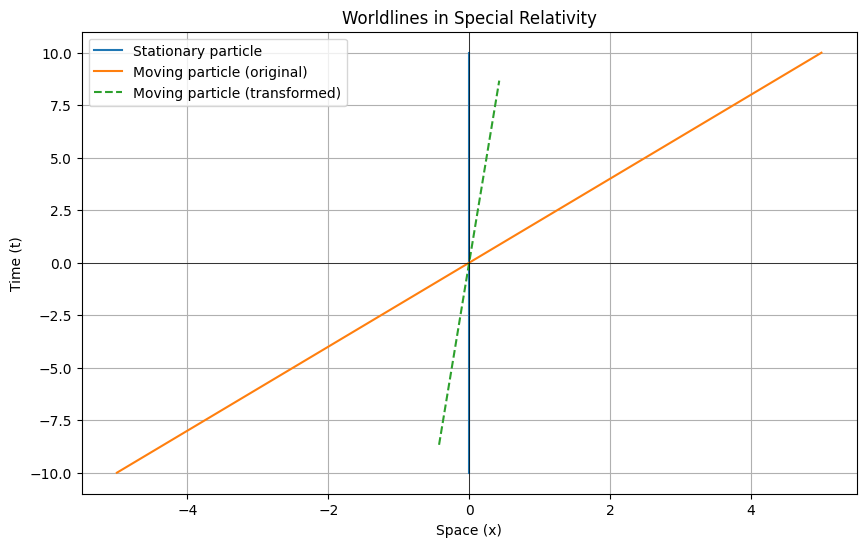

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import lambdify

# Lorentz transformation components
t_prime = cosh(eta) * t - sinh(eta) * x
x_prime = -sinh(eta) * t + cosh(eta) * x

# Convert to numerical functions
eta_val = 0.5  # Example value for rapidity
t_prime_func = lambdify((t, x), t_prime.subs(eta, eta_val), 'numpy')
x_prime_func = lambdify((t, x), x_prime.subs(eta, eta_val), 'numpy')

# Generate data for worldlines
t_vals = np.linspace(-10, 10, 400)

# Stationary particle
x_vals_stationary = np.zeros_like(t_vals)

# Moving particle
v = 0.5  # Speed as a fraction of the speed of light
x_vals_moving = v * t_vals

# Apply Lorentz transformation
t_prime_vals = t_prime_func(t_vals, x_vals_moving)
x_prime_vals = x_prime_func(t_vals, x_vals_moving)

# Plot the worldlines
plt.figure(figsize=(10, 6))

# Plot the stationary particle's worldline
plt.plot(x_vals_stationary, t_vals, label='Stationary particle')

# Plot the moving particle's worldline
plt.plot(x_vals_moving, t_vals, label='Moving particle (original)')
plt.plot(x_prime_vals, t_prime_vals, label='Moving particle (transformed)', linestyle='dashed')

# Labels and legend
plt.xlabel('Space (x)')
plt.ylabel('Time (t)')
plt.title('Worldlines in Special Relativity')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
# plt.gca().set_aspect('equal')
plt.legend()
plt.grid(True)
plt.show()

**Note:** On a spacetime diagram, hyperbolas can represent lines of constant proper time.

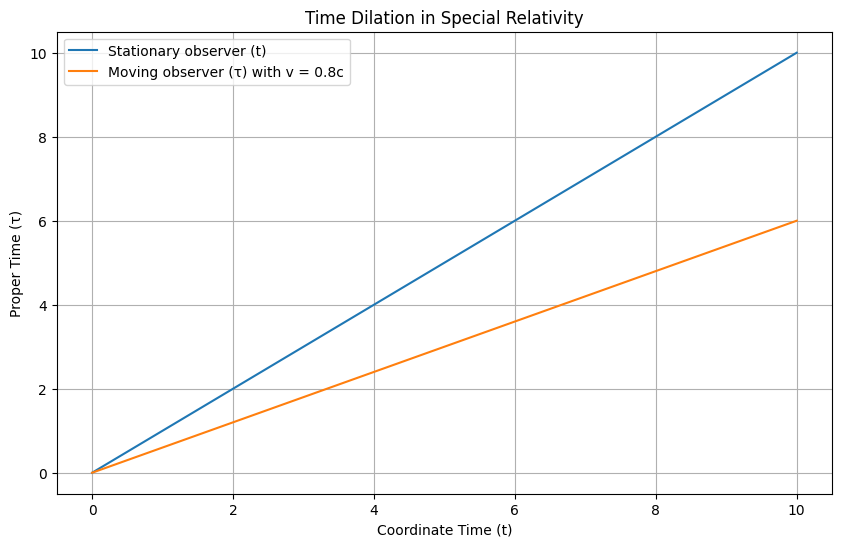

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, sqrt, lambdify

# Define symbols
t, v = symbols('t v')
gamma = 1 / sqrt(1 - v**2)

# Define proper time τ
tau = t / gamma

# Convert to numerical function
tau_func = lambdify((t, v), tau, 'numpy')

# Generate data
t_vals = np.linspace(0, 10, 400)
v_val = 0.8  # Example velocity as a fraction of the speed of light
tau_vals = tau_func(t_vals, v_val)

# Plot the worldlines and time dilation
plt.figure(figsize=(10, 6))

# Plot the coordinate time vs. proper time
plt.plot(t_vals, t_vals, label='Stationary observer (t)')
plt.plot(t_vals, tau_vals, label=f'Moving observer (τ) with v = {v_val}c')

# Labels and legend
plt.xlabel('Coordinate Time (t)')
plt.ylabel('Proper Time (τ)')
plt.title('Time Dilation in Special Relativity')
plt.legend()
plt.grid(True)
plt.show()

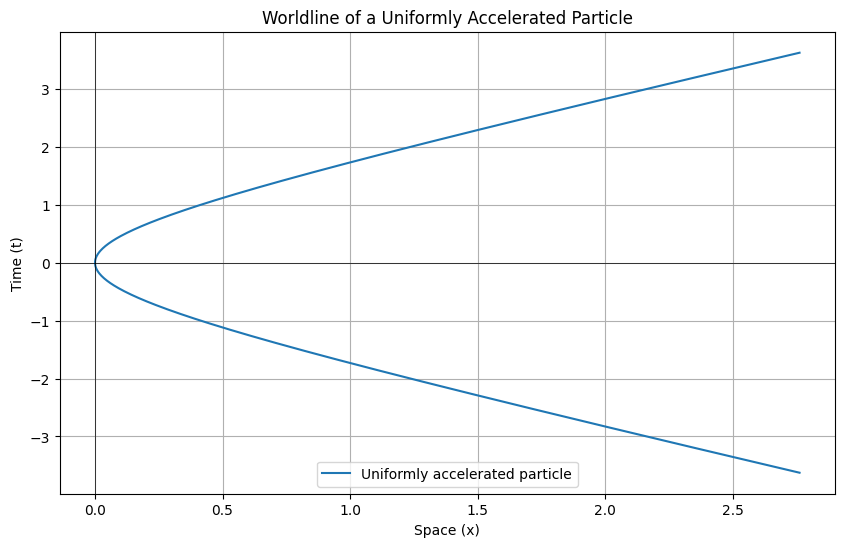

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, cosh, sinh, lambdify

# Define symbols
tau, a = symbols('tau a')

# Hyperbolic trajectory equations
x_tau = (cosh(a * tau) - 1) / a
t_tau = sinh(a * tau) / a

# Convert to numerical functions
a_val = 1.0  # Example value for proper acceleration
x_func = lambdify(tau, x_tau.subs(a, a_val), 'numpy')
t_func = lambdify(tau, t_tau.subs(a, a_val), 'numpy')

# Generate data for worldline
tau_vals = np.linspace(-2, 2, 400)
x_vals = x_func(tau_vals)
t_vals = t_func(tau_vals)

# Plot the worldline
plt.figure(figsize=(10, 6))

# Plot the worldline of the uniformly accelerated particle
plt.plot(x_vals, t_vals, label='Uniformly accelerated particle')

# Labels and legend
plt.xlabel('Space (x)')
plt.ylabel('Time (t)')
plt.title('Worldline of a Uniformly Accelerated Particle')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.show()

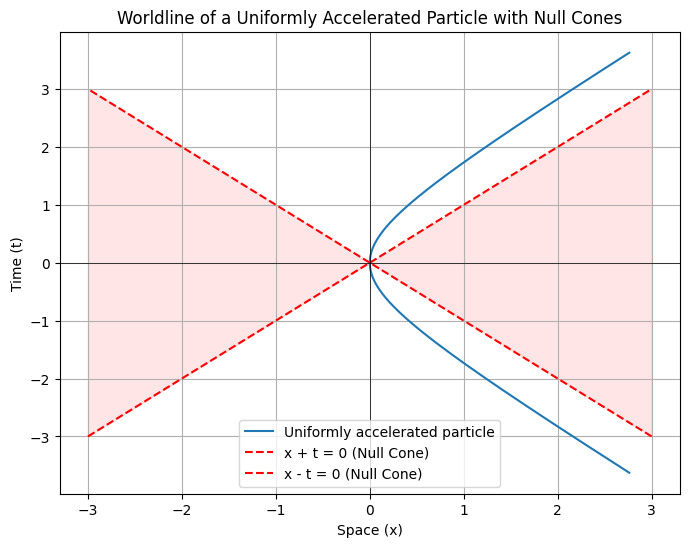

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, cosh, sinh, lambdify

# Define symbols
tau, a = symbols('tau a')

# Hyperbolic trajectory equations
x_tau = (cosh(a * tau) - 1) / a
t_tau = sinh(a * tau) / a

# Convert to numerical functions
a_val = 1.0  # Example value for proper acceleration
x_func = lambdify(tau, x_tau.subs(a, a_val), 'numpy')
t_func = lambdify(tau, t_tau.subs(a, a_val), 'numpy')

# Generate data for worldline
tau_vals = np.linspace(-2, 2, 400)
x_vals = x_func(tau_vals)
t_vals = t_func(tau_vals)

# Generate data for null cones
null_t_vals = np.linspace(-3, 3, 2)
null_x_plus_t = null_t_vals  # x + t = 0
null_x_minus_t = -null_t_vals  # x - t = 0

# Plot the worldline
plt.figure(figsize=(8, 6))

# Plot the worldline of the uniformly accelerated particle
plt.plot(x_vals, t_vals, label='Uniformly accelerated particle')

# Plot the null cones
plt.plot(null_x_plus_t, null_t_vals, 'r--', label='x + t = 0 (Null Cone)')
plt.plot(null_x_minus_t, null_t_vals, 'r--', label='x - t = 0 (Null Cone)')
plt.fill_between(null_t_vals, null_x_plus_t, null_x_minus_t, color='r', alpha=0.1, interpolate=True)

# Labels and legend
plt.xlabel('Space (x)')
plt.ylabel('Time (t)')
plt.title('Worldline of a Uniformly Accelerated Particle with Null Cones')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b2b4ca2a-af01-4555-80d1-14c6a6cbeed3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>